In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [24]:
DATA_PATH = r'C:\Users\shail\Desktop\NSL\data'

In [25]:
categories = sorted(os.listdir(DATA_PATH))
print(f"Categories: {categories}")

Categories: ['1', '2', '3', '4', '5', '6', '7', '8', '9']


In [38]:
def load_images_and_labels(data_path, categories, img_size=(64, 64)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(category)
    return np.array(images, dtype=np.float16), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(DATA_PATH, categories)

In [27]:
# Encoding labels
label_binarizer = LabelBinarizer()
labels_encoded = label_binarizer.fit_transform(labels)

In [28]:
labels_encoded[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
X_train, X_test, y_labels, y_test_labels = train_test_split(images, labels_encoded, test_size=0.3, random_state=42)

In [30]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [31]:
datagen = ImageDataGenerator(
    rotation_range=10,          
    zoom_range=0.1,              
    width_shift_range=0.1,       
    height_shift_range=0.1,      
    horizontal_flip=True,       
    fill_mode="nearest"        
)

datagen.fit(X_train)


LOADING PRETRAINED MODEL VGG16

In [57]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [38]:
X_train[0].shape

(64, 64, 3)

In [39]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=X_train[0].shape)

In [40]:
base_model.trainable = False

In [41]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [42]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

CUSTOM OUTPUT LAYERS

In [82]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Flatten()(x)
x = Dense(128, activation='relu')(x)  
x = Dense(64, activation='relu')(x)  


predictions = Dense(len(categories), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

In [83]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [84]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights = True)

In [85]:
model.fit(X_train, y_labels, epochs=50,  validation_data=(X_test, y_test), batch_size=32, callbacks=[es])

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.1307 - loss: 2.3510 - val_accuracy: 0.1210 - val_loss: 2.0990
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.1980 - loss: 2.1042 - val_accuracy: 0.1925 - val_loss: 1.9619
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.3229 - loss: 1.8810 - val_accuracy: 0.4418 - val_loss: 1.5760
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4590 - loss: 1.5346 - val_accuracy: 0.5780 - val_loss: 1.2921
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5783 - loss: 1.2583 - val_accuracy: 0.5668 - val_loss: 1.0738
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6289 - loss: 1.0581 - val_accuracy: 0.7407 - val_loss: 0.8837
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6906 - loss: 0.8671 - val_accuracy: 0.7242 - val_loss: 0.8125
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7327 - loss: 0.7466 - val_accu

In [89]:
model.save('_pretrained_vgg16.keras')

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(X_train[0].shape))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Flatten()(x)  
x = Dense(128, activation='relu')(x) 
x = Dense(64, activation='relu')(x)   


predictions = Dense(len(categories), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 70, 70, 3)         │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 32, 32, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 32, 32, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 32, 32, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 34, 34, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 16, 16, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 16, 16, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 16, 16, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 16, 16, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 16, 16, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,858,825 (91.01 MB)

 Trainable params: 271,113 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [41]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights = True)

In [48]:
history = model.fit(X_train, y_labels, validation_data=(X_test, y_test_labels), epochs=3, batch_size=32, callbacks=[es])

Epoch 1/3
 45/237 ━━━━━━━━━━━━━━━━━━━━ 1:29 466ms/step - accuracy: 1.0000 - loss: 0.0100

KeyboardInterrupt: 

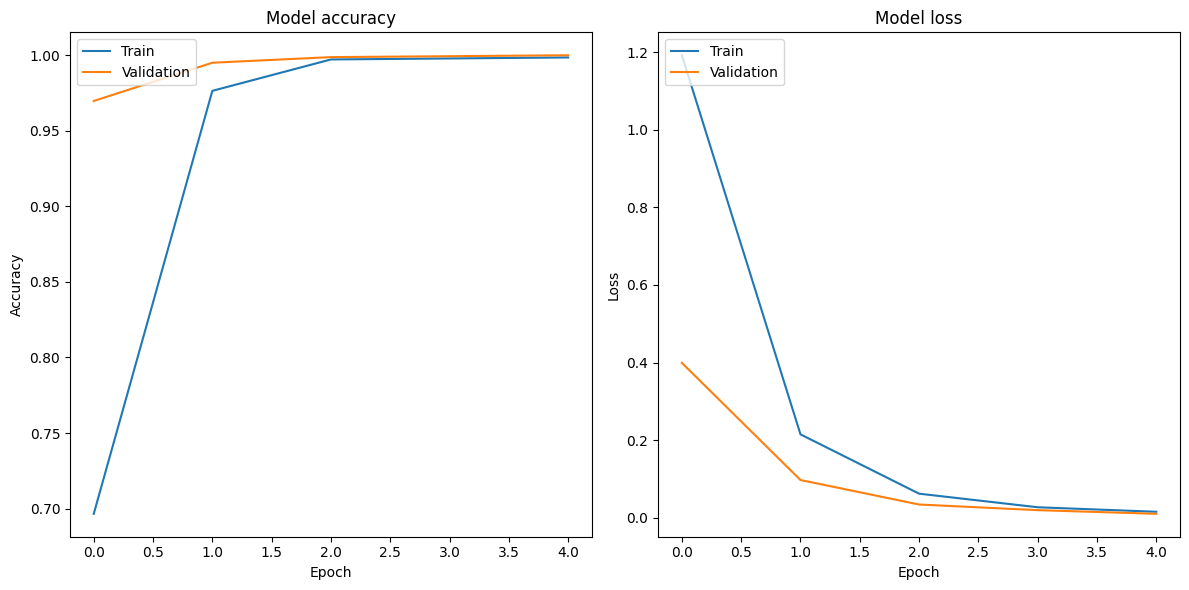

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()

In [44]:
model.save('_pretrained_resnet50.keras')

First image to predict:


TypeError: only integer scalar arrays can be converted to a scalar index

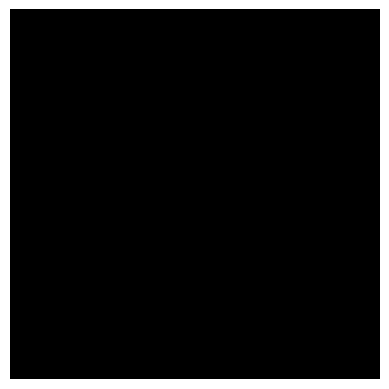

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure that X_test is a NumPy array, so no need to call `.numpy()`
# For the first image, we directly access it from the NumPy array

for i in range(1):  # Loop through more images if needed
    first_image = X_test[i].astype('uint8')  # No need for .numpy(), since it's already a NumPy array
    plt.axis('off')
    first_label = y_test_labels[i]  # Get the actual label for this image

    print("First image to predict:")
    plt.imshow(first_image)
    print("Actual:  ", categories[first_label])  # Display the actual label

    # Predict using the model (reshape the input into a batch format as the model expects a batch)
    batch_prediction = model.predict(np.expand_dims(X_test[i], axis=0))  
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])  # Display predicted label

# Prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # img is already a NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)  # Get model prediction
    predicted_class = class_names[np.argmax(predictions[0])]  # Get predicted class
    confidence = round(100 * (np.max(predictions[0])), 2)  # Calculate confidence
    return predicted_class, confidence

# Example usage of the predict function:
predicted_class, confidence = predict(model, X_test[0])  # Pass a test image to predict
print(f"Predicted: {predicted_class} with confidence {confidence}%")
